# Nigg and Herzog model
### Introduction to modeling and simulation of human movement

Desiree Miraldo  
Renato Naville Watanabe  
Marcos Duarte

https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

* In class:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Muscle properties

In [2]:
Lslack = .223

Lce_o = .086 #optmal length

Fmax = 3000


### Initial conditions

In [3]:
LceNorm = .087/Lce_o
Lm = .31
Act = 0
t0 = 0
tf = 7.99
h = 1e-3
phi = np.pi/2
phid = 0

Rf = 0.033
m = 10  
g = 9.81    
Rcm = 0.264 
I = 0.1832  
Rf = 0.033  
alpha = 0 

In [4]:
t = np.arange(t0,tf,h)
F = np.zeros(t.shape)
Fkpe = np.zeros(t.shape)
fiberLength = np.empty(t.shape)
tendonLength = np.empty(t.shape)
activation = np.zeros(t.shape)
neural = np.zeros(t.shape)
alfa = np.deg2rad(45)
phi_dynamics = np.empty(t.shape)

fiberLength[0] = LceNorm * Lce_o * np.cos(alfa)
tendonLength[0] = Lm - fiberLength[0]

In [5]:
def computeTendonForce(LseeNorm, Lslack, Lce_o):
    '''
    Compute Tendon Force
    
    Inputs:
    
    LseeNorm - Normalized Tendon  length
    
    Lslack - slack length of the tendon (non-normalized)
    
    Lce_o - Optimal length of the fiber
    
    Output:
    
    FtendonNorm - Normalized tendon force
    '''
    
    Umax = .04
    if LseeNorm<Lslack/Lce_o: 
        FTendonNorm = 0
    else: 
        FTendonNorm = ((LseeNorm-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return FTendonNorm

In [6]:
def computeParallelElementForce(LceNorm):
    Umax = 1
    if LceNorm < 1: 
        FkpeNorm = 0
    else: 
        FkpeNorm = ((LceNorm-1)/(Umax))**2 
        
    return FkpeNorm

In [7]:
def computeForceLengthCurve(LceNorm):
    width = .63
    FLNorm = max([0, (1-((LceNorm-1)/width)**2)])
    return FLNorm

In [8]:
def computeContractileElementDerivative(act, FLNorm, FCENorm):
     #calculate CE velocity from Hill's equation
    '''
    a = .25
    b = .25*10
    
    if  FCENorm > act*FLNorm:
        print('Error: cannot do eccentric contractions')
    
    LceNormdot = -b*(act*FLNorm-FCENorm)/(a+FCENorm) 
    '''
    
    A = 0.25
    
    F_m_len = 1.4 #young
    #F_m_len = 1.8 #old
    v_max = 10 #young
    #v_max = 8 #old
    
    FCE = min((F_m_len*act*FLNorm-1e-4), FCENorm)
    
    if FCE <= act*FLNorm:
        b = act*FLNorm + FCE/A
        
    else:
        b = (2 + 2/A)*(act*FLNorm*F_m_len + FCE)/(F_m_len - 1)
        #b = act*FLNorm + FCENorm/A
        
    LceNormdot = (0.25 + 0.75*act)*v_max*(FCE - act*FLNorm)/b
    
    return LceNormdot

In [9]:
def computeContractileElementForce(FtendonNorm, FkpeNorm, alfa):
    FCENorm = FtendonNorm/np.cos(alfa) - FkpeNorm
    return FCENorm

In [10]:
def computeTendonLength(Lm, Lce_o, LceNorm, alfa):
    LseeNorm = Lm/Lce_o - LceNorm*np.cos(alfa)
    return LseeNorm

In [11]:
def computeActivation(Act, n, dt):
    
    tau = 0.12
    
    dActdt = (n-Act)/tau
    Act = Act + dt*dActdt
    
    return Act

## Simulation - Parallel

In [12]:
for i in range (1,len(t)):
    Lm = 0.31 - (phi-np.pi/2)*Rf
    
    # activation      
        
    n = 0.7 + 0.2*np.sin(np.pi*t[i])
        
    ########################################################
    LseeNorm = computeTendonLength(Lm, Lce_o, LceNorm, alfa)
    
    FTendonNorm = computeTendonForce(LseeNorm, Lslack, Lce_o)
        
    FkpeNorm = computeParallelElementForce(LceNorm)
      
    FLNorm = computeForceLengthCurve(LceNorm)    
    
    FCENorm = computeContractileElementForce(FTendonNorm, FkpeNorm, alfa)
    
    activation[i] = computeActivation(activation[i-1], n, h)
    
    LceNormdot = computeContractileElementDerivative(activation[i], FLNorm, FCENorm)
    
    M = Rf*FTendonNorm - m*g*Rcm*np.sin(phi-np.pi/2)
    phidd = M/I 
    
    LceNorm = LceNorm + h*LceNormdot
    phid = phid + phidd*h
    phi  = phi + phid*h
    #########################################################################
    F[i] = FTendonNorm * Fmax
    Fkpe[i] = FkpeNorm * Fmax
    fiberLength[i] = LceNorm * Lce_o
    tendonLength[i] = LseeNorm * Lce_o
    phi_dynamics[i] = phi
    

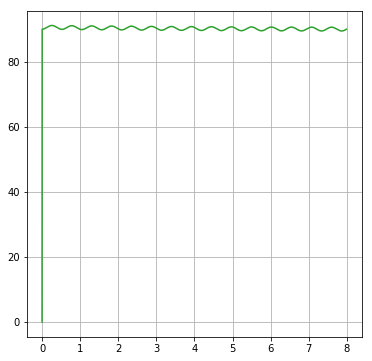

In [18]:

fig, ax  =  plt.subplots(1,1, figsize=(6,6), sharex=True)

ax.plot(t,phi_dynamics*180/np.pi,c='tab:green')
plt.grid()


## Plot 

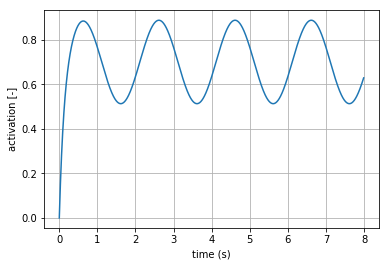

In [14]:
plt.figure()

plt.plot(t,activation)
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('activation [-]')
plt.show()

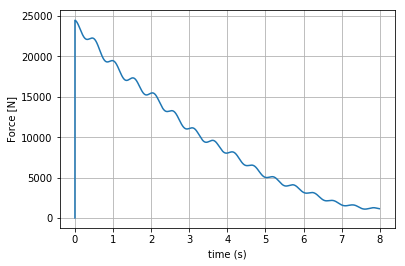

In [15]:

plt.figure()

plt.plot(t,F)

plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force [N]')
plt.show()

#ax.legend()

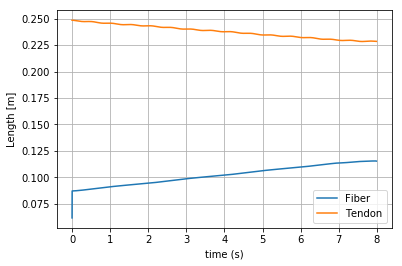

In [16]:
plt.figure()
plt.plot(t,fiberLength, label = 'Fiber')
plt.plot(t, tendonLength, label = 'Tendon')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time (s)')
plt.ylabel('Length [m]');
plt.show()


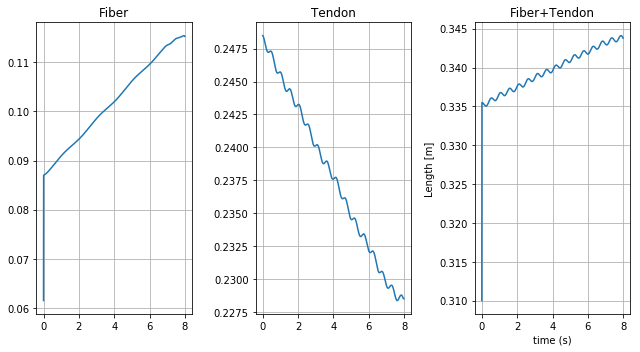

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(9, 5), sharex=True)

ax[0].plot(t, fiberLength, label = 'Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendonLength, label = 'Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
ax[2].plot(t, fiberLength+tendonLength, label = 'Fiber+Tendon')
ax[2].set_title('Fiber+Tendon')
ax[2].grid()
plt.xlabel('time (s)')
plt.ylabel('Length [m]')
plt.tight_layout()